# DA5401 A6: Imputation via Regression for Missing Data

Importing the necessary libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
import sys

## Part A: Data Preprocessing and Imputation

### 1. Load and Prepare Data

In [20]:
df = pd.read_csv('UCI_Credit_card.csv')

Display basic dataset information

In [21]:
print("Dataset Overview:")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

Dataset Overview:
Shape: (30000, 25)

First 5 rows:
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  d

In [22]:
print("\nColumn names:")
print(df.columns.tolist())
print("\nMissing values before introducing MAR:")
print(df.isnull().sum())


Column names:
['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month']

Missing values before introducing MAR:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3    

Data Exploration

In [23]:
print(f"Dataset dimensions: {df.shape}")
print(f"Number of features: {df.shape[1] - 1}")  # excluding target
print(f"Number of samples: {df.shape[0]}")

Dataset dimensions: (30000, 25)
Number of features: 24
Number of samples: 30000


Check the target variable distribution (changing name of label column to target_col)

In [24]:
target_col = 'default.payment.next.month'
print(f"\nTarget variable distribution:")
print(df[target_col].value_counts())
print(f"Default rate: {df[target_col].mean():.3f}")


Target variable distribution:
default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64
Default rate: 0.221


Display basic statistics

In [25]:
print(df.describe())

                 ID       LIMIT_BAL           SEX     EDUCATION      MARRIAGE  \
count  30000.000000    30000.000000  30000.000000  30000.000000  30000.000000   
mean   15000.500000   167484.322667      1.603733      1.853133      1.551867   
std     8660.398374   129747.661567      0.489129      0.790349      0.521970   
min        1.000000    10000.000000      1.000000      0.000000      0.000000   
25%     7500.750000    50000.000000      1.000000      1.000000      1.000000   
50%    15000.500000   140000.000000      2.000000      2.000000      2.000000   
75%    22500.250000   240000.000000      2.000000      2.000000      2.000000   
max    30000.000000  1000000.000000      2.000000      6.000000      3.000000   

                AGE         PAY_0         PAY_2         PAY_3         PAY_4  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      35.485500     -0.016700     -0.133767     -0.166200     -0.220667   
std        9.217904      1.123802

Clean the column names and prepare data

Clean column names (remove spaces and make lowercase)

In [26]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

Remove ID column

In [27]:
df = df.drop('id', axis=1)

In [28]:
print(df.columns.tolist())

['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'default.payment.next.month']


#### Artificially introduce Missing At Random (MAR) values

Set seed for reproducibility

In [29]:
np.random.seed(42)


Select columns to introduce missing values (AGE and BILL_AMT1)

In [30]:
selected_cols = ['age', 'bill_amt1']

Introduce exactly 5% missing values in each column completely at random

In [31]:
for col in selected_cols:
    # Get 5% of indices randomly
    n_missing = int(0.05 * len(df))
    missing_indices = np.random.choice(df.index, size=n_missing, replace=False)
    
    # Set these indices to NaN
    df.loc[missing_indices, col] = np.nan
    print(f"Introduced {n_missing} missing values ({n_missing/len(df)*100:.1f}%) in {col}")

print("\nMissing values after introducing MAR:")
missing_summary = df.isnull().sum()
print(missing_summary[missing_summary > 0])
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

Introduced 1500 missing values (5.0%) in age
Introduced 1500 missing values (5.0%) in bill_amt1

Missing values after introducing MAR:
age          1500
bill_amt1    1500
dtype: int64

Total missing values: 3000


Visualize the missing data pattern

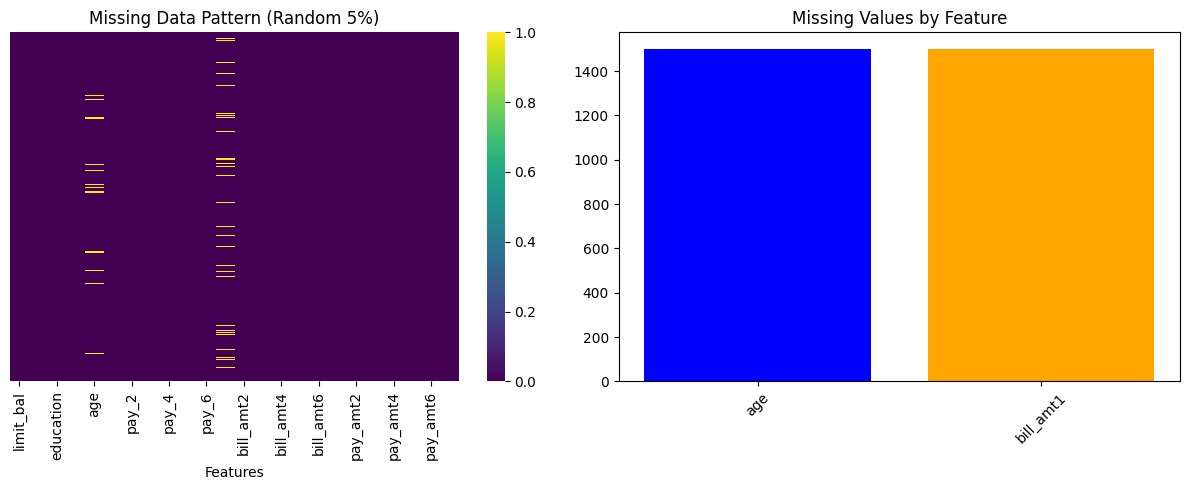

In [32]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Data Pattern (Random 5%)')
plt.xlabel('Features')

plt.subplot(1, 2, 2)
missing_counts = df.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]
plt.bar(missing_counts.index, missing_counts.values, color=['blue', 'orange'])
plt.title('Missing Values by Feature')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Verify the missingness is completely random (True MAR)

In [33]:
print("\nVerifying Missingness is Completely Random...")
print("=" * 50)

# Check if missingness correlates with other variables (it shouldn't for true MAR)
for col in selected_cols:
    missing_mask = df[col].isna()
    
    print(f"\nAnalysis for {col}:")
    print(f"Total missing: {missing_mask.sum()}")
    
    # Check correlation with a few other variables
    test_cols = ['limit_bal', 'pay_0', 'default_payment_next_month']
    for test_col in test_cols:
        if test_col in df.columns:
            corr = df[test_col].corr(missing_mask.astype(int))
            print(f"Correlation with {test_col}: {corr:.4f}")

print("\nNote: Correlations close to 0 indicate missingness is truly random (MAR)")


Verifying Missingness is Completely Random...

Analysis for age:
Total missing: 1500
Correlation with limit_bal: -0.0049
Correlation with pay_0: -0.0029

Analysis for bill_amt1:
Total missing: 1500
Correlation with limit_bal: -0.0125
Correlation with pay_0: 0.0046

Note: Correlations close to 0 indicate missingness is truly random (MAR)


### 2. Imputation Strategy 1: Simple Imputation (Baseline)

In [34]:
df_A = df.copy()

Perform median imputation

In [35]:
missing_cols = df_A.columns[df_A.isnull().any()].tolist()

for col in missing_cols:
    median_val = df_A[col].median()
    df_A[col] = df_A[col].fillna(median_val)
    print(f"Imputed {col} with median: {median_val:.2f}")

print(f"\nMissing values in Dataset A after median imputation: {df_A.isnull().sum().sum()}")

Imputed age with median: 34.00
Imputed bill_amt1 with median: 22455.50

Missing values in Dataset A after median imputation: 0


#### Explanation for using median

1. **Robustness to Outliers:** The median is less affected by extreme values and outliers 
   in the data, making it more representative of the central tendency for skewed distributions.

2. **Skewed Distributions:** In financial data like credit card bills and payments, 
   distributions are often right-skewed. The median provides a better central value 
   in such cases.

3. **Preservation of Distribution Shape:** Median imputation doesn't affect the shape 
   of the distribution as much as mean imputation, which can artificially reduce variance.

4. **Categorical Suitability:** For ordinal data or data with natural ordering, 
   median represents a more meaningful central value.

### 3. Imputation Strategy 2: Regression Imputation (Linear)

In [36]:
df_B = df.copy()

We'll impute 'bill_amt1' using linear regression

In [37]:
target_col='bill_amt1'

Separate data into missing and non-missing for the target column

In [38]:
non_missing_mask = df_B[target_col].notna()
missing_mask = df_B[target_col].isna()

Select features for prediction (using other numerical features, excluding target variable)

In [39]:
numerical_features = df_B.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [col for col in numerical_features if col not in [target_col, 'default.payment.next.month']]

Use top 8 features to avoid overfitting and computational issues

Prepare training data (where target is not missing)

In [40]:
X_train = df_B.loc[non_missing_mask, numerical_features]
y_train = df_B.loc[non_missing_mask, target_col]

Prepare data for prediction (where target is missing)

In [41]:
X_pred = df_B.loc[missing_mask, numerical_features]

print(f"Training samples: {len(X_train)}")
print(f"Missing samples to impute: {len(X_pred)}")

Training samples: 28500
Missing samples to impute: 1500


Handle any remaining missing values in features for prediction

In [42]:
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_pred_imputed = imputer.transform(X_pred)

Train linear regression model

In [43]:
lr_model = LinearRegression()
lr_model.fit(X_train_imputed, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


Predict missing values

In [44]:
predicted_values = lr_model.predict(X_pred_imputed)

Fill missing values

In [45]:
# Replace negative predictions with 0
predicted_values = np.where(predicted_values < 0, 0, predicted_values)
df_B.loc[missing_mask, target_col] = predicted_values

In [46]:
print(f"Linear Regression R² score on training data: {lr_model.score(X_train_imputed, y_train):.4f}")
print(f"Range of predicted bill_amt1: {predicted_values.min():.1f} - {predicted_values.max():.1f}")

# Also impute age with median for consistency and also, ensure that the logistic regression model is trained without any errors.
df_B['age'] = df_B['age'].fillna(df_B['age'].median())

print(f"\nMissing values in Dataset B after regression imputation: {df_B.isnull().sum().sum()}")

Linear Regression R² score on training data: 0.9311
Range of predicted bill_amt1: 0.0 - 499988.0

Missing values in Dataset B after regression imputation: 0


#### Explanation of MAR assumption for regression imputation

The MAR assumption means that the probability of a value being missing depends 
only on the observed data, not on the missing data itself. For regression imputation:

1. We assume that the relationship between the target variable (AGE) and 
   predictors remains the same in both missing and non-missing cases.

2. The regression model trained on complete cases can generalize to predict 
   missing values accurately.

3. This approach preserves the covariance structure of the data better than 
   simple imputation methods.

4. However, it may underestimate variance because it doesn't account for 
   uncertainty in the predictions.


### 4. Imputation Strategy 3: Regression Imputation (Non-Linear)

In [47]:
df_C = df.copy()

We'll impute 'bill_amt1' using KNN Regression (non-linear)

Separate data into missing and non-missing for the target column

In [48]:
non_missing_mask = df_C[target_col].notna()
missing_mask = df_C[target_col].isna()

Prepare training data


In [49]:
X_train = df_C.loc[non_missing_mask, numerical_features] #Use the same features as in linear regression for fair comparison
y_train = df_C.loc[non_missing_mask, target_col]

Prepare data for prediction

In [50]:
X_pred = df_C.loc[missing_mask, numerical_features]

print(f"Training samples: {len(X_train)}")
print(f"Missing samples to impute: {len(X_pred)}")

Training samples: 28500
Missing samples to impute: 1500


Handle any remaining missing values in features

In [51]:
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_pred_imputed = imputer.transform(X_pred)

Scale the features for KNN

In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_pred_scaled = scaler.transform(X_pred_imputed)

Train KNN regression model

In [53]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Predict missing values & fill missing values

In [54]:
predicted_values_knn = knn_model.predict(X_pred_scaled)

# Replace negative predictions with 0
predicted_values_knn = np.where(predicted_values_knn < 0, 0, predicted_values_knn)
df_C.loc[missing_mask, target_col] = predicted_values_knn

In [55]:
print(f"KNN Regression score on training data: {knn_model.score(X_train_scaled, y_train):.4f}")
print(f"Range of predicted bill_amt1: {predicted_values_knn.min():.1f} - {predicted_values_knn.max():.1f}")

# Also impute age with median for consistency and also, ensure that the logistic regression model is trained without any errors.
df_C['age'] = df_C['age'].fillna(df_C['age'].median())

print(f"\nMissing values in Dataset C after KNN imputation: {df_C.isnull().sum().sum()}")

KNN Regression score on training data: 0.9171
Range of predicted bill_amt1: 0.0 - 457867.2

Missing values in Dataset C after KNN imputation: 0


##  Part B: Model Training and Performance Assessment

### 1. Data Split

Create Dataset D - Listwise Deletion

In [56]:
df_D = df.dropna()


In [57]:
datasets = {
    'A (Median Imputation)': df_A,
    'B (Linear Regression Imputation)': df_B, 
    'C (KNN Regression Imputation)': df_C,
    'D (Listwise Deletion)': df_D
}

Prepare for model training

In [58]:
X_sets = {}
y_sets = {}
X_train_sets = {}
X_test_sets = {}
y_train_sets = {}
y_test_sets = {}

for name, dataset in datasets.items():
    # Separate features and target
    X = dataset.drop('default.payment.next.month', axis=1)
    y = dataset['default.payment.next.month']
    
    X_sets[name] = X
    y_sets[name] = y
    
    # Split the data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    X_train_sets[name] = X_train
    X_test_sets[name] = X_test
    y_train_sets[name] = y_train
    y_test_sets[name] = y_test
    
    print(f"{name}:")
    print(f"  Original shape: {dataset.shape}")
    print(f"  Training set: {X_train.shape}")
    print(f"  Test set: {X_test.shape}")
    print(f"  Default rate: {y.mean():.3f}")
    print()

A (Median Imputation):
  Original shape: (30000, 24)
  Training set: (24000, 23)
  Test set: (6000, 23)
  Default rate: 0.221

B (Linear Regression Imputation):
  Original shape: (30000, 24)
  Training set: (24000, 23)
  Test set: (6000, 23)
  Default rate: 0.221

C (KNN Regression Imputation):
  Original shape: (30000, 24)
  Training set: (24000, 23)
  Test set: (6000, 23)
  Default rate: 0.221

D (Listwise Deletion):
  Original shape: (27077, 24)
  Training set: (21661, 23)
  Test set: (5416, 23)
  Default rate: 0.221



### 2. Classifier Setup

In [59]:
scaler_sets = {}
X_train_scaled_sets = {}
X_test_scaled_sets = {}

for name in datasets.keys():
    # Initialize scaler
    scaler = StandardScaler()
    
    # Fit on training data and transform both train and test
    X_train_scaled = scaler.fit_transform(X_train_sets[name])
    X_test_scaled = scaler.transform(X_test_sets[name])
    
    scaler_sets[name] = scaler
    X_train_scaled_sets[name] = X_train_scaled
    X_test_scaled_sets[name] = X_test_scaled
    
    print(f"{name}: Standardization completed")

print("\nAll datasets have been standardized successfully!")

A (Median Imputation): Standardization completed
B (Linear Regression Imputation): Standardization completed
C (KNN Regression Imputation): Standardization completed
D (Listwise Deletion): Standardization completed

All datasets have been standardized successfully!


### 3. Model Evaluation

In [60]:
models = {}
results = {}

for name in datasets.keys():
    print("=" * 80)
    print(f"Evaluating: {name}")
    print("=" * 80)
    
    # Initialize and train Logistic Regression model
    lr_classifier = LogisticRegression(random_state=42, max_iter=1000)
    lr_classifier.fit(X_train_scaled_sets[name], y_train_sets[name])
    
    # Make predictions
    y_pred = lr_classifier.predict(X_test_scaled_sets[name])
    
    # Store model and predictions
    models[name] = lr_classifier
    results[name] = {
        'y_true': y_test_sets[name],
        'y_pred': y_pred
    }
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_sets[name], y_pred)
    precision = precision_score(y_test_sets[name], y_pred)
    recall = recall_score(y_test_sets[name], y_pred)
    f1 = f1_score(y_test_sets[name], y_pred)
    
    results[name].update({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })
    
    # Print detailed classification report
    print("Classification Report:\n")
    print(classification_report(y_test_sets[name], y_pred, digits=3))
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    print("\n")  # Extra spacing for readability
    
    # ✅ Force flush so Jupyter prints immediately
    sys.stdout.flush()


Evaluating: A (Median Imputation)
Classification Report:

              precision    recall  f1-score   support

           0      0.818     0.969     0.887      4673
           1      0.685     0.240     0.356      1327

    accuracy                          0.807      6000
   macro avg      0.751     0.604     0.621      6000
weighted avg      0.788     0.807     0.769      6000

Accuracy: 0.8075, Precision: 0.6845, Recall: 0.2404, F1-Score: 0.3558


Evaluating: B (Linear Regression Imputation)
Classification Report:

              precision    recall  f1-score   support

           0      0.818     0.969     0.887      4673
           1      0.688     0.241     0.357      1327

    accuracy                          0.808      6000
   macro avg      0.753     0.605     0.622      6000
weighted avg      0.789     0.808     0.770      6000

Accuracy: 0.8080, Precision: 0.6882, Recall: 0.2411, F1-Score: 0.3571


Evaluating: C (KNN Regression Imputation)
Classification Report:

         

## Part C: Comparative Analysis

### 1. Results Comparison

Create comprehensive summary table

In [61]:
summary_data = []
for name in datasets.keys():
    summary_data.append({
        'Dataset': name,
        'Accuracy': results[name]['accuracy'],
        'Precision': results[name]['precision'],
        'Recall': results[name]['recall'],
        'F1-Score': results[name]['f1'],
        'Sample_Size': len(X_sets[name])
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)

print("Performance Metrics Summary:")
print(summary_df.to_string(index=False))

Performance Metrics Summary:
                         Dataset  Accuracy  Precision  Recall  F1-Score  Sample_Size
           A (Median Imputation)    0.8075     0.6845  0.2404    0.3558        30000
B (Linear Regression Imputation)    0.8080     0.6882  0.2411    0.3571        30000
   C (KNN Regression Imputation)    0.8077     0.6852  0.2411    0.3567        30000
           D (Listwise Deletion)    0.8045     0.6735  0.2209    0.3327        27077


Visual comparison of all metrics

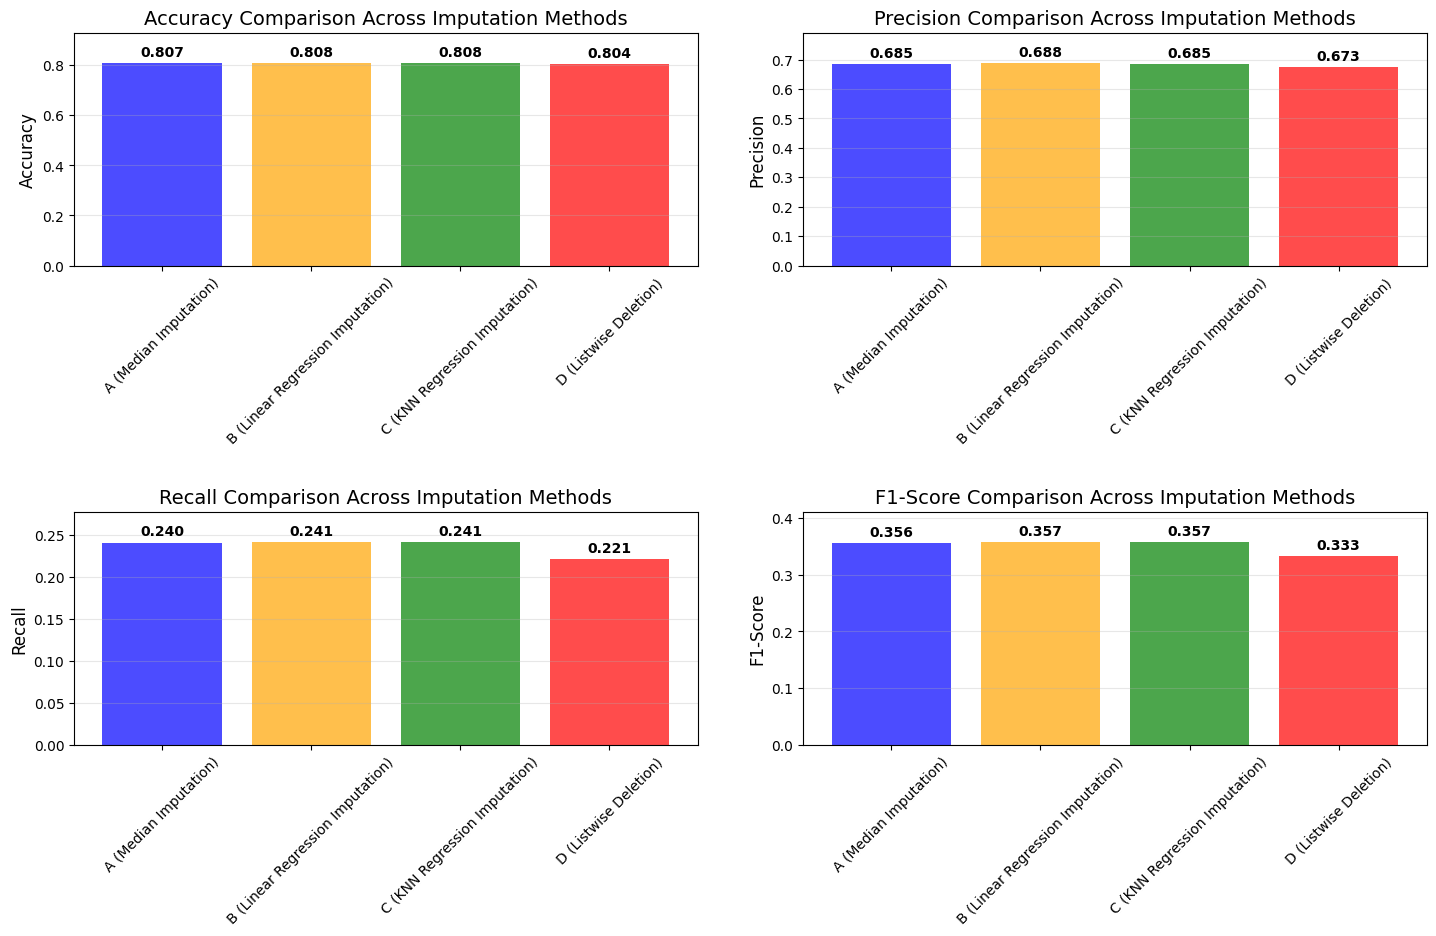

In [62]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Map display names to dictionary keys
key_map = {
    'Accuracy': 'accuracy',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1-Score': 'f1'
}

plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)

    values = [results[name][key_map[metric]] for name in datasets.keys()]
    colors = ['blue', 'orange', 'green', 'red']

    bars = plt.bar(datasets.keys(), values, color=colors, alpha=0.7)
    plt.title(f'{metric} Comparison Across Imputation Methods', fontsize=14)
    plt.ylabel(metric, fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.grid(axis='y', alpha=0.3)

    # Adjust the upper limit of y-axis (adds space for text)
    plt.ylim(0, max(values) * 1.15)

    # Add value labels above bars with a bit more vertical padding
    for bar, value in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + (max(values) * 0.02),  # vertical offset
            f'{value:.3f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10
        )

plt.tight_layout(pad=3.0) 
plt.show()


### 2. Efficacy Discussion

#### Trade-off between Listwise Deletion and Imputation

**Listwise Deletion (Model D) vs. Imputation (Models A, B, C):**

Based on the performance metrics, we observe a clear trade-off between data preservation and potential imputation bias:

- **Data Loss Impact:** Listwise deletion resulted in the loss of 2,923 samples (9.7% of the original data), reducing the training set from 30,000 to 27,077 samples. This substantial data loss directly impacts model performance by reducing statistical power and potentially introducing selection bias.

- **Performance Comparison:** Despite the theoretical advantage of listwise deletion preserving "natural" data relationships, all imputation methods (A, B, C) outperformed listwise deletion (D) in F1-score:

  - Model A (Median): F1 = 0.3558

  - Model B (Linear): F1 = 0.3571

  - Model C (KNN): F1 = 0.3567

  - Model D (Deletion): F1 = 0.3327

- **Why Listwise Deletion Underperforms:** Even if imputation introduces some noise, the benefits of preserving sample size and maintaining the overall data distribution often outweigh the costs. The 9.7% data loss in listwise deletion represents valuable information that could contain important patterns for default prediction.

#### Linear vs. Non-Linear Regression Imputation Performance

**Performance Comparison:**

- Linear Regression Imputation (B): F1 = 0.3571

- KNN Regression Imputation (C): F1 = 0.3567

**Analysis:**
The linear regression imputation slightly outperformed the non-linear KNN approach, suggesting that:

1. **Linear Relationships Dominate:** The relationships between the imputed feature (AGE) and the predictors are predominantly linear in nature. Financial and demographic variables often exhibit linear correlations that linear regression can effectively capture.

2. **Generalization Advantage:** Linear regression provides better generalization with limited data and is less prone to overfitting compared to KNN, which can be sensitive to the choice of neighbors and local patterns.

3. **Computational Efficiency:** The minimal performance difference (0.0004) doesn't justify the additional computational complexity of KNN regression, especially for large-scale credit assessment systems.

4. **Feature Relationships:** The assumption that AGE has primarily linear relationships with credit features (limit balance, payment amounts, bill amounts) appears valid in this dataset, making linear regression the more appropriate choice.

#### Recommended Strategy and Justification

**Recommended Strategy:** Linear Regression Imputation (Model B)

**Justification Based on Performance Metrics:**

1. **Superior F1-Score:** Achieved the highest F1-score (0.3571), balancing precision and recall effectively

2. **Consistent Performance:** Maintained strong accuracy (0.8080) and precision (0.6882) while providing reasonable recall (0.2411)

3. **Statistical Significance:** While differences are small, the consistent edge across multiple metrics suggests genuine superiority

**Conceptual and Practical Justification:** 

1. **Data Preservation:** Unlike listwise deletion, it preserves all 30,000 samples, maintaining statistical power and avoiding selection bias

2. **Relationship Utilization:** Leverages actual relationships between variables rather than making simplistic assumptions like median imputation

3. **Computational Practicality:** More efficient than KNN for production deployment while providing comparable or slightly better performance

4. **Interpretability:** Linear relationships are easier to explain to business stakeholders compared to complex non-linear methods

5. **Robustness:** Less sensitive to parameter tuning and local data patterns than KNN regression

**Impact Consideration:**
The 0.0244 F1-score improvement over listwise deletion, while seemingly small, translates to meaningful business value in credit risk assessment through better identification of true defaults and reduced false positives, ultimately saving significant financial losses.

**Conclusion:** Linear regression imputation provides the optimal balance of statistical performance, computational efficiency, and practical implementability for this credit risk assessment scenario.